# MultiModal RAG

참조 - [Langchain 공식 블로그](https://blog.langchain.dev/semi-structured-multi-modal-rag/)





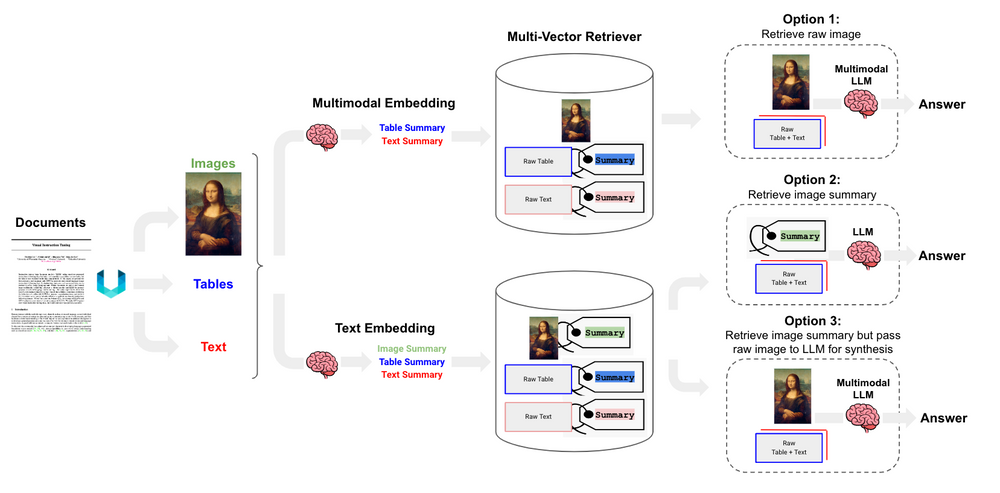

- PDF 에서 내용을 추출한 후, 각 요소들을 어떻게 다룰 것이냐에 대한 고민이 필요합니다.
- PDF 파일의 형태에 따라 우수한 방법은 모두 다릅니다.
- 본 실습에서는 SKT 의 2023 TCFD 보고서를 기준으로 진행합니다.
  - [다운로드 링크](https://www.sktelecom.com/img/pds/persist_biz/2023/SKT_TCFD_Report_2023(KOR).pdf)
- 질문: 위의 옵션들 중 어떤 방법이 가장 적절할까요?

## 1. PDF 자르기

- PDF 에서 text, table, images 와 같은 요소들을 추출합니다.
  - [unstructured](https://unstructured.io/) 라이브러리를 사용합니다.
- 각 요소들을 글을 요약합니다.
- 이 떄, 텍스트가 아닌 요소들을 요약해야하므로 multimodal model 이 필요합니다.
  - (ex) GPT-4V, GPT-4o, LLaVa, PaliGemma
  - 2024년 6월 기준 GPT-4o가 가장 성능이 좋다고 평가되므로 GPT-4o 를 사용합니다.

In [ ]:
# 필요한 라이브러리 설치
!pip install pdf2image
!sudo apt-get install poppler-utils
# 설치 확인
!pdftoppm -h

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 0s (1,746 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 12191

In [ ]:
!pip install -U langchain openai langchain-experimental  langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib tiktoken

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (27.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [ ]:
# 파일 경로 설정 (폴더 생성 할 것)
fpath = "/content/pdf/"
f_path_image="/content/pdf/images/"
fname = "SKT_TCFD_2023.pdf"

!wget "https://www.sktelecom.com/img/pds/persist_biz/2023/SKT_TCFD_Report_2023(KOR).pdf" -O ./pdf/SKT_TCFD_2023.pdf

--2024-06-12 04:21:53--  https://www.sktelecom.com/img/pds/persist_biz/2023/SKT_TCFD_Report_2023(KOR).pdf
Resolving www.sktelecom.com (www.sktelecom.com)... 13.107.246.67, 2620:1ec:bdf::67
Connecting to www.sktelecom.com (www.sktelecom.com)|13.107.246.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9606398 (9.2M) [application/pdf]
Saving to: ‘./pdf/SKT_TCFD_2023.pdf’

./pdf/SKT_TCFD_2023 100%[===================>]   9.16M  1.61MB/s    in 5.7s    

2024-06-12 04:22:02 (1.61 MB/s) - ‘./pdf/SKT_TCFD_2023.pdf’ saved [9606398/9606398]



In [ ]:
# PDF 분할하기 - 오래 걸림: Colab CPU 8분 소요

import os
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

# PDF에서 요소 추출
def extract_pdf_elements(path, fname):
    """
    PDF 파일에서 이미지, 테이블, 텍스트, 기타 정보를 추출합니다.
    path: 이미지(.jpg)를 저장할 파일 경로
    fname: 파일 이름
    """
    return partition_pdf(
        filename=os.path.join(path, fname),
        extract_images_in_pdf=True,  # PDF 내 이미지 추출 활성화
        infer_table_structure=True,  # 테이블 구조 추론 활성화
        chunking_strategy="by_title",  # 제목별로 텍스트 조각화
        max_characters=4000,  # 최대 문자 수
        new_after_n_chars=3800,  # 이 문자 수 이후에 새로운 조각 생성
        combine_text_under_n_chars=2000,  # 이 문자 수 이하의 텍스트는 결합
        image_output_dir_path=path,  # 이미지 출력 디렉토리 경로
    )

# 요소를 유형별로 분류
def categorize_elements(raw_pdf_elements):
    """
    PDF에서 추출된 요소를 테이블, 텍스트, 이미지, 기타 정보로 분류합니다.
    raw_pdf_elements: unstructured.documents.elements의 리스트
    """
    tables = []  # 테이블 저장 리스트
    texts = []  # 텍스트 저장 리스트
    images = []  # 이미지 저장 리스트
    others = []  # 기타 정보 저장 리스트

    for element in raw_pdf_elements:
        element_type = str(type(element))
        if "unstructured.documents.elements.Table" in element_type:
            tables.append(str(element))  # 테이블 요소 추가
        elif "unstructured.documents.elements.CompositeElement" in element_type:
            texts.append(str(element))  # 텍스트 요소 추가
        elif "unstructured.documents.elements.Image" in element_type:
            images.append(str(element))  # 이미지 요소 추가
        else:
            others.append(str(element))  # 기타 정보 요소 추가

    return texts, tables, images, others

raw_pdf_elements = extract_pdf_elements(fpath, fname)

# 텍스트, 테이블, 이미지, 기타 정보 추출
texts, tables, images, others = categorize_elements(raw_pdf_elements)

# 선택사항: 텍스트에 대해 특정 토큰 크기 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0  # 텍스트를 4000 토큰 크기로 분할, 중복 없음
)
joined_texts = " ".join(texts)  # 텍스트 결합
texts_4k_token = text_splitter.split_text(joined_texts)  # 분할 실행

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tables[5]

'시점 유형 기회 요인 단기 중기 장기 ① 효율적 생산 및 유통 프로세스 자원효율성 ② 재활용 활성화 ③ EMS(에너지효율관리 서비스) 등 솔루션 도입 Needs 증가 ④ 저배출 에너지원 사용 에너지원 ⑤ 탄소시장 참여 ⑥ 재생에너지 발전 사업 매출 및 초과 에너지 판매 ⑦ 저배출 제품 및 서비스 매출 증가 ⑧ 소비자 선호도 증가 ⑨ 통신서비스에 대한 수요 증가 ⑩ ICT 기술 기반 솔루션 공급 확대 ⑪ ICT 기술 기반 에너지 사업을 통한 배출권 매출 ⑫ 재생에너지 발전 및 판매로 인한 수익 증가 ⑬ 공공부문 인센티브 활용 시장 잠재적인 영향 대응 현황 및 계획 효율성 향상으로 생산 및 유통 비용 절감 ･ AI 기반 디지털 유통 채널 확대 재활용에 따른 폐기물 처리 비용 절감 ･ 철거 단계에 적용 가능한 재활용률 증가 방안 개발 ･ 폐기물 배출량 관련 제3자 검증 실시 에너지관리 서비스 수요 증가에 따른 매출 증가 ･ AI/ICT 기반 고효율 저탄소 에너지 관리기술 제공 (BEMS, FEMS, LEMS) 확대 에너지 조달 시 가격 상승에 따른 위험 감소 ･ PPA와 REC 등 재생에너지 활용 온실가스 감축 사업을 통한 배출권 수익 증가 ･ 탄소배출량 관리 및 탄소배출권 관리 재생에너지 발전 사업 매출 및 초과 에너지 판매로 인한 수익 증가 ･ 국내 사업장 자가 발전소 설치 ･ 재생에너지 PPA 사업 투자 저탄소 제품 및 서비스 수요 증가에 따른 매출 증가 ･ AI/ICT 기반 저탄소 서비스 운영 ･ 전자 청구서, 모바일 멤버십 운영 적극적인 기후변화 대응으로 기업 이미지 제고 ･ ‘선제적 기후변화 대응’, ‘환경경영 시스템 고도화’, ‘친환경 그린 컬처 조성’ 추진 기후변화 관련 서비스 수요 증가에 따른 매출 확대 ･ 소비자 수요 데이터 분석을 바탕으로 한 친환경 서비스 및 제품 개발 ICT 기반 에너지 솔루션 시장 기회 확대 ･ Vision AI 등 핵심기술 개발 및 적용 ･ AI 에너지효율관리 서비스(EMS) 기반 솔루션 개발 및 적용 ICT 기반 에너지

In [ ]:
# 모든 페이지를 image로 바꾸기

from pdf2image import convert_from_path
from PIL import Image
import os

# Function to extract images from a PDF and save them as JPG
def extract_images_from_pdf(pdf_path, output_folder):
    # Convert PDF to a list of images
    images = convert_from_path(pdf_path)

    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each image and save as JPG
    for page_num, image in enumerate(images):
        image_output_path = os.path.join(output_folder, f"image_{page_num + 1}.jpg")
        image.save(image_output_path, "JPEG")
        print(f"Saved image: {image_output_path}")


pdf_path = os.path.join(fpath, fname)
output_folder = f_path_image
extract_images_from_pdf(pdf_path, output_folder)

Saved image: /content/pdf/images/image_1.jpg
Saved image: /content/pdf/images/image_2.jpg
Saved image: /content/pdf/images/image_3.jpg
Saved image: /content/pdf/images/image_4.jpg
Saved image: /content/pdf/images/image_5.jpg
Saved image: /content/pdf/images/image_6.jpg
Saved image: /content/pdf/images/image_7.jpg
Saved image: /content/pdf/images/image_8.jpg
Saved image: /content/pdf/images/image_9.jpg
Saved image: /content/pdf/images/image_10.jpg
Saved image: /content/pdf/images/image_11.jpg
Saved image: /content/pdf/images/image_12.jpg
Saved image: /content/pdf/images/image_13.jpg
Saved image: /content/pdf/images/image_14.jpg
Saved image: /content/pdf/images/image_15.jpg
Saved image: /content/pdf/images/image_16.jpg
Saved image: /content/pdf/images/image_17.jpg
Saved image: /content/pdf/images/image_18.jpg
Saved image: /content/pdf/images/image_19.jpg
Saved image: /content/pdf/images/image_20.jpg
Saved image: /content/pdf/images/image_21.jpg
Saved image: /content/pdf/images/image_22.j

## 각 요소들을 요약하기

모델에 따라 가격이 많이 나올 수 있습니다 ㅠㅠ
필요하다면 Local LLM 을 도입할 수 있습니다!

- text 요약은 GPT-4 가 제일 잘 하고, 제일 비쌉니다.
- Image 는 Multimodal 모델이 필요하니 GPT-4o 를 사용합니다.

In [ ]:
import os

os.environ['OPENAI_API_KEY'] =  "" # OPENAI API key 입력

In [ ]:
# GPT-4 비용 - $1.35

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 텍스트 요소의 요약 생성
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    텍스트 요소 요약
    texts: 문자열 리스트
    tables: 문자열 리스트
    summarize_texts: 텍스트 요약 여부를 결정. True/False
    """

    # 프롬프트 설정
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # 텍스트 요약 체인
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # 요약을 위한 빈 리스트 초기화
    text_summaries = []
    table_summaries = []

    # 제공된 텍스트에 대해 요약이 요청되었을 경우 적용
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # 제공된 테이블에 적용
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# 텍스트, 테이블 요약 가져오기
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [ ]:
table_summaries[5]

'The text discusses various short, medium, and long-term opportunities and factors related to efficient production and distribution processes, recycling, energy efficiency management services (EMS), low-emission energy sources, carbon market participation, renewable energy generation, and increased sales of low-emission products and services. It also mentions the potential impact of increased consumer preference, demand for communication services, expansion of ICT technology-based solutions, and sales of emission rights through ICT-based energy businesses. The text further outlines plans and current status of responses, including cost reduction through efficiency improvement, waste disposal cost reduction through recycling, sales increase due to increased demand for energy management services, risk reduction due to price increases in energy procurement, and increased profits from emission rights through greenhouse gas reduction projects.'

In [ ]:
# 이미지 (pdf의 각 페이지를 image 로 만든 이미지) 도 요약
# figures 는 생략. 실습 데이터 기준 의미가 없다, 논문과 같은 형태였다면 의미가 있었을 것
# GPT-4o 사용 - 3분, $0.25

import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    # 이미지 파일을 base64 문자열로 인코딩합니다.
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    # 이미지 요약을 생성합니다.
    chat = ChatOpenAI(model="gpt-4o", max_tokens=2048)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    이미지에 대한 요약과 base64 인코딩된 문자열을 생성합니다.
    path: Unstructured에 의해 추출된 .jpg 파일 목록의 경로
    """

    # base64로 인코딩된 이미지를 저장할 리스트
    img_base64_list = []

    # 이미지 요약을 저장할 리스트
    image_summaries = []

    # 요약을 위한 프롬프트
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # 이미지에 적용
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# 이미지 요약 실행
img_base64_list, image_summaries = generate_img_summaries(f_path_image)

In [ ]:
image_summaries[9]

'Summary: A table from SK Telecom\'s TCFD Report 2023 titled "기회 요인 중대성 평가 결과" (Opportunity Factors Materiality Assessment Results). The table is organized into columns labeled 유형 (Type), 기회 요인 (Opportunity Factors), 시점 (Timing: Short, Medium, Long Term), 잠재적인 영향 (Potential Impact), and 대응 현황 및 계획 (Current Status and Plans). Rows categorize opportunities under 자원효율성 (Resource Efficiency), 에너지원 (Energy Source), 제품 및 서비스 (Products and Services), and 시장 (Market). The table uses filled circles to indicate the relevance of each opportunity factor over different time frames and provides detailed plans and impacts for each factor.'

# 2. 잘린 PDF 요소들을 VectorDB 에 저장합니다

- Embedding 모델로는 summary 와 text 들을 기준으로 사용합니다
-   VectorDB 로는 Pinecone 을 사용합니다
  - [Pinecone](https://www.pinecone.io/) 에 접속해서 Database 를 만들어 봅시다
-   (선택 실습) ChromaDB 로 로컬에 저장해볼 수 있습니다




In [ ]:
# Pinecone 설치
!pip install pinecone-client[grpc] langchain-pinecone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-pinecone to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 13.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-pinecone to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.5/214.5 kB 15.3 MB/s eta 0:00:00
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If

In [ ]:
# Pinecone API 로 database 생성
# 본 실습에서는 직접 web interface 로 만들어 봅시다.

from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

pc = Pinecone(api_key='2c01199e-7155-405c-95f6-57e1e5afc3c2')

index_name = "skt-test"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=3072,
        metric="cosine",
        spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
  )

In [ ]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Pinecone

from langchain_pinecone import PineconeVectorStore

# Pinecone 초기화
os.environ['PINECONE_API_KEY'] = ''

def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    요약을 색인화하지만 원본 이미지나 텍스트를 반환하는 검색기를 생성합니다.
    """

    # 저장 계층 초기화
    store = InMemoryStore()
    id_key = "doc_id"

    # 멀티 벡터 검색기 생성
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 문서를 벡터 저장소와 문서 저장소에 추가하는 헬퍼 함수
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [
            str(uuid.uuid4()) for _ in doc_contents
        ]  # 문서 내용마다 고유 ID 생성
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(
            summary_docs
        )  # 요약 문서를 벡터 저장소에 추가
        retriever.docstore.mset(
            list(zip(doc_ids, doc_contents))
        )  # 문서 내용을 문서 저장소에 추가

    # 텍스트, 테이블, 이미지 추가
    if text_summaries:
        add_documents(retriever, text_summaries, texts)

    if table_summaries:
        add_documents(retriever, table_summaries, tables)

    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

# 요약을 색인화하기 위해 사용할 벡터 저장소
# pincone app setting required.
vectorstore = PineconeVectorStore(
    index_name="skt-test", embedding=OpenAIEmbeddings(model="text-embedding-3-large")
)

# 검색기 생성
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)


In [ ]:
# 검색 결과 확인
query = "ESG위원회의 역할과 책임 에 대해서 정리해서 알려줘"
docs = retriever_multi_vector_img.invoke(query)

# 문서의 개수 확인
len(docs)

4

In [ ]:
docs[0]

str

In [ ]:
docs = retriever_multi_vector_img.vectorstore.similarity_search(query)

In [ ]:
docs[0]

Document(page_content='Summary: SK Telecom ESG Committee Governance Page - roles, responsibilities, and key ESG activities for 2022. Korean text.', metadata={'doc_id': '67b19064-5748-4e5d-9a6e-b528831fd4b7'})

# Docstore (원본 저장소) Export

- Pinecone VectorDB 에는 doc_id 와 embedded vecotor, summary 만 저장됩니다.
- 원본은 현재 이 instance 의 memory 에 저장되어있기 때문에, 날아갈 수 있으니 저장을 해야합니다.
- docstore 를 다른 storeage 로 생성하는 방법도 있습니다.

In [ ]:
import json

# 데이터를 dictionary로 변환
store_data = dict(retriever_multi_vector_img.docstore.store.items())

# JSON 파일로 저장
with open("store_data.json", "w") as json_file:
    json.dump(store_data, json_file)

# 3. RAG Chain 생성

- Langchain 의 LCEL 을 이용해서 RAG 체인 생성
- Langsmith 를 이용해서 모니터링 연



In [ ]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """base64 인코딩된 문자열을 이미지로 표시"""
    # base64 문자열을 소스로 사용하는 HTML img 태그 생성
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTML을 렌더링하여 이미지 표시
    display(HTML(image_html))


def looks_like_base64(sb):
    """문자열이 base64로 보이는지 확인"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    base64 데이터가 이미지인지 시작 부분을 보고 확인
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # 처음 8바이트를 디코드하여 가져옴
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Base64 문자열로 인코딩된 이미지의 크기 조정
    """
    # Base64 문자열 디코드
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # 이미지 크기 조정
    resized_img = img.resize(size, Image.LANCZOS)

    # 조정된 이미지를 바이트 버퍼에 저장
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 조정된 이미지를 Base64로 인코딩
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    base64로 인코딩된 이미지와 텍스트 분리
    """
    b64_images = []
    texts = []
    for doc in docs:
        # 문서가 Document 타입인 경우 page_content 추출
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    컨텍스트를 단일 문자열로 결합
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 이미지가 있으면 메시지에 추가
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 분석을 위한 텍스트 추가
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. Answer in Korean. Do NOT translate company names.\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    멀티모달 RAG 체인
    """

    # 멀티모달 LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=2048)

    # RAG 파이프라인
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# RAG 체인 생성
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [ ]:
# RAG 체인 실행
print(chain_multimodal_rag.invoke(query))

In [ ]:
import os
from uuid import uuid4

unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"SKT Tracing - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = ""  # Update to your API key